## This python notebook plots up bottom & 100m mean temperature from the CESM2-LE for antarctic SIZ

#### set up paths

In [1]:
feisty_dir='/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'
fig_dir='/glade/work/kristenk/figs'

In [2]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
from dask_jobqueue import PBSCluster
import warnings
warnings.filterwarnings('ignore')
import pop_tools
from glob import glob
import utils
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

### Grab pre-processed ocean temp on bottom temperature

In [4]:
def preprocess(ds):
    ds = ds.isel(nlat=slice(0,55))
    return ds

In [5]:
%%time
files = sorted(glob(f'{feisty_dir}/drivers/mesozooC_zint_100m/CESM2-LE_HIST_SSP370_mesozooC_zint_100m_????????.nc'))       
ds2 = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()
ds2['mesozooC_zint_100m'] = ds2.mesozooC_zint_100m.where(ds2.mesozooC_zint_100m > 0.001).where(ds2.mesozooC_zint_100m < 10000)

CPU times: user 10.6 s, sys: 3min 38s, total: 3min 48s
Wall time: 5min 11s


In [6]:
%%time
files = sorted(glob(f'{feisty_dir}/drivers/TEMP_bottom/CESM2-LE_HIST_SSP370_TEMP_bottom_????????.nc'))       
ds = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 56.9 s, sys: 7.26 s, total: 1min 4s
Wall time: 2min 17s


In [10]:
%%time
files = sorted(glob(f'{feisty_dir}/drivers/TEMP_100m/CESM2-LE_HIST_SSP370_TEMP_mean_100m_????????.nc'))       
ds_tmp = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 2min 45s, sys: 11 s, total: 2min 56s
Wall time: 4min 30s


In [12]:
%%time
files = sorted(glob(f'{feisty_dir}/drivers/POC_FLUX_bottom/CESM2-LE_HIST_SSP370_pocToFloor_????????.nc'))       
ds_tmp2 = xr.open_mfdataset(files, concat_dim="member_id", combine='nested',preprocess=preprocess).compute()

CPU times: user 2min 27s, sys: 8.22 s, total: 2min 35s
Wall time: 4min 8s


In [13]:
ds['TEMP_100m'] = ds_tmp.TEMP

In [14]:
ds['mesozooC_zint_100m'] = ds2.mesozooC_zint_100m

In [15]:
ds['pocToFloor'] = ds_tmp2.pocToFloor

### Get some DASK going to speed up processing

In [16]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='30 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=30GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ext', # Interface to use
)
# Scale up
cluster.scale(20)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [17]:
client

Client Scheduler: tcp://128.117.208.187:43523 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make annual means

In [18]:
%%time

ds = ds.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 40.4 s, sys: 9.85 s, total: 50.2 s
Wall time: 53.9 s


In [19]:
ds['time'] = np.arange(1850,2101,1)

In [20]:
ds = ds.isel(time=slice(70,250))

In [21]:
ds = ds.load()

### ToE calculation

In [22]:
time3d = np.full([180,55,320],1,dtype=int)

ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

In [23]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['TEMP_bottom','TEMP_100m','pocToFloor','mesozooC_zint_100m']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 447 ms, sys: 87.2 ms, total: 534 ms
Wall time: 537 ms


In [24]:
ToE_down_TEMP_100m = time3d.where(ds.TEMP_100m.mean(dim='member_id') < lothres_ds['TEMP_100m'])
ToE_down_TEMP_100m = ToE_down_TEMP_100m.min(dim='time')

ToE_down_TEMP_bottom = time3d.where(ds.TEMP_bottom.mean(dim='member_id') < lothres_ds['TEMP_bottom'])
ToE_down_TEMP_bottom = ToE_down_TEMP_bottom.min(dim='time')

In [25]:
ToE_up_TEMP_100m = time3d.where(ds.TEMP_100m.mean(dim='member_id') > upthres_ds['TEMP_100m'])
ToE_up_TEMP_100m = ToE_up_TEMP_100m.min(dim='time')

ToE_up_TEMP_bottom = time3d.where(ds.TEMP_bottom.mean(dim='member_id') > upthres_ds['TEMP_bottom'])
ToE_up_TEMP_bottom = ToE_up_TEMP_bottom.min(dim='time')

In [26]:
ToE_down_POCfloor = time3d.where(ds.pocToFloor.mean(dim='member_id') < lothres_ds['pocToFloor'])
ToE_down_POCfloor = ToE_down_POCfloor.min(dim='time')

ToE_down_mesozooC = time3d.where(ds.mesozooC_zint_100m.mean(dim='member_id') < lothres_ds['mesozooC_zint_100m'])
ToE_down_mesozooC = ToE_down_mesozooC.min(dim='time')

In [27]:
ToE_up_POCfloor = time3d.where(ds.pocToFloor.mean(dim='member_id') > upthres_ds['pocToFloor'])
ToE_up_POCfloor = ToE_up_POCfloor.min(dim='time')

ToE_up_mesozooC = time3d.where(ds.mesozooC_zint_100m.mean(dim='member_id') > upthres_ds['mesozooC_zint_100m'])
ToE_up_mesozooC = ToE_up_mesozooC.min(dim='time')

In [28]:
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))
ds_siz_mask

<xarray.Dataset>
Dimensions:  (nlat: 55, nlon: 320)
Coordinates:
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SIZ      (nlat, nlon) float64 ...

In [29]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


### Maps of ToE

In [30]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=13)

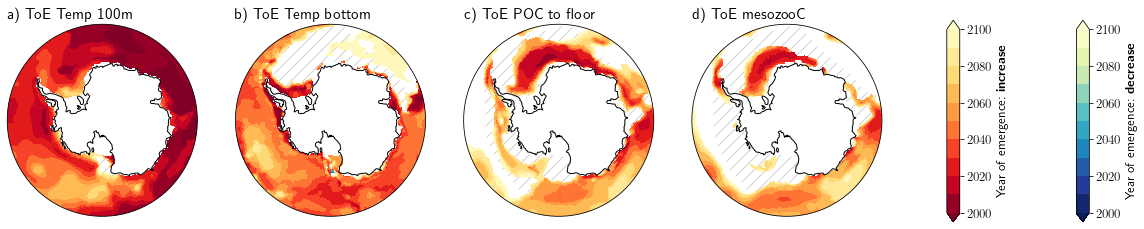

In [31]:
fig = plt.figure(figsize=(18,4))
levels=np.arange(2000,2110,10)

#########################################################
ax = fig.add_subplot(1,4,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE Temp 100m', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_100m)

pc1 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_100m)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)

#########################################################
ax = fig.add_subplot(1,4,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE Temp bottom', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_bottom)

pc1 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_bottom)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('c) ToE POC to floor', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_POCfloor)

pc1 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_POCfloor)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


######################
ax = fig.add_subplot(1,4,4, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('d) ToE mesozooC', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_mesozooC)

pc1 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_mesozooC)

pc2 = ax.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)





fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label=r'Year of emergence: \textbf{increase}')


cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label=r'Year of emergence: \textbf{decrease}')

### make SIZ timeseries

In [32]:
ts_siz = xr.Dataset()

for v in ['TEMP_bottom','TEMP_100m','pocToFloor','mesozooC_zint_100m']:


    masked_area = area.where(ds_siz_mask['SIZ']==1)
    
    masked_var = ds[v].where(ds_siz_mask['SIZ']==1)
    masked_area['nlat'] = ds_siz_mask['SIZ'].nlat
    masked_area['nlon'] = ds_siz_mask['SIZ'].nlon
    
    ts_siz[v] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        

In [33]:
years = ts_siz.time

In [34]:
mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_temp100m = ts_siz['TEMP_100m']['time'].where(ts_siz['TEMP_100m'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_temp100m_val = mean+2*std
print(toe_temp100m,toe_temp100m_val)

<xarray.DataArray 'time' ()>
array(1986.) -1.268038557529306


In [35]:
mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_temp_bot = ts_siz['TEMP_bottom']['time'].where(ts_siz['TEMP_bottom'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_temp_bot_val = mean+2*std
print(toe_temp_bot,toe_temp_bot_val)

<xarray.DataArray 'time' ()>
array(1999.) 1.158422038787581


In [36]:
mean = ts_siz['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_poc2floor = ts_siz['pocToFloor']['time'].where(ts_siz['pocToFloor'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_poc2floor_val = mean+2*std
print(toe_poc2floor,toe_poc2floor_val)

<xarray.DataArray 'time' ()>
array(2014.) 0.00016886567868653208


In [37]:
mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_mesozooC = ts_siz['mesozooC_zint_100m']['time'].where(ts_siz['mesozooC_zint_100m'].mean(dim='member_id') > mean+2*std).min(dim='time')
toe_mesozooC_val = mean+2*std
print(toe_mesozooC,toe_mesozooC_val)

<xarray.DataArray 'time' ()>
array(2012.) 1328.4471687311386


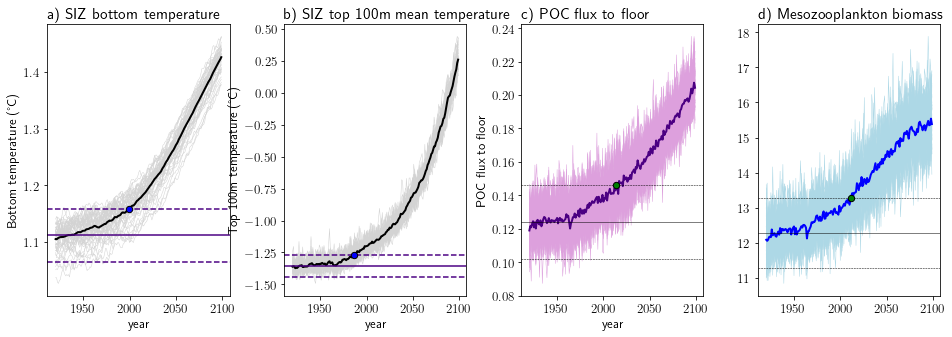

In [38]:
fig = plt.figure(figsize=(16,5))

######################################################

ax = fig.add_subplot(1,4,1)

ax.set_title('a) SIZ bottom temperature',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_bottom'].isel(member_id=mem), color='lightgray', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_bottom'].mean(dim='member_id'), color='black', linewidth=2)

mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')
ax.scatter(toe_temp_bot,toe_temp_bot_val,s=40,color='blue',edgecolor='black',zorder=3)
ax.set(xlabel='year',ylabel='Bottom temperature (°C)');
#ax.set_ylim(0,1.6)



####################################
ax = fig.add_subplot(1,4,2)

ax.set_title('b) SIZ top 100m mean temperature',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['TEMP_100m'].isel(member_id=mem), color='lightgray', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['TEMP_100m'].mean(dim='member_id'), color='black', linewidth=2)

mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')
ax.scatter(toe_temp100m,toe_temp100m_val,s=40,color='blue',edgecolor='black',zorder=3)
ax.set(xlabel='year',ylabel='Top 100m temperature (°C)');
#ax.set_ylim(0,1.6)

fig.subplots_adjust(wspace=0.3)


convert = 0.01 * 86400

######################################################

ax = fig.add_subplot(1,4,3)

ax.set_title('c) POC flux to floor',loc='left')

for mem in np.arange(0,48,1):
    ax.plot(years, ts_siz['pocToFloor'].isel(member_id=mem)*convert, color='plum', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['pocToFloor'].mean(dim='member_id')*convert, color='indigo', linewidth=2, label='POC to ocean floor')

mean = ts_siz['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*convert
std = ts_siz['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*convert
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax.set(xlabel='year',ylabel='POC flux to floor ');
ax.scatter(toe_poc2floor,toe_poc2floor_val*convert,s=40,color='green',edgecolor='black',zorder=3)
##############################################################

ax = fig.add_subplot(1,4,4)
ax.set_title('d) Mesozooplankton biomass',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years, ts_siz['mesozooC_zint_100m'].isel(member_id=mem)*0.01, color='lightblue', linewidth=0.5)
    
## plot means

ax.plot(years, ts_siz['mesozooC_zint_100m'].mean(dim='member_id')*0.01, color='blue', linewidth=2, label='Mesozoo biomass')

mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.01
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.01
ax.axhline(mean, color='black', linewidth=0.5)
ax.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)

ax.scatter(toe_mesozooC,toe_mesozooC_val*0.01,s=40,color='green',edgecolor='black',zorder=3)


### Now put line plots and maps together and adjust colors

In [39]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=12)

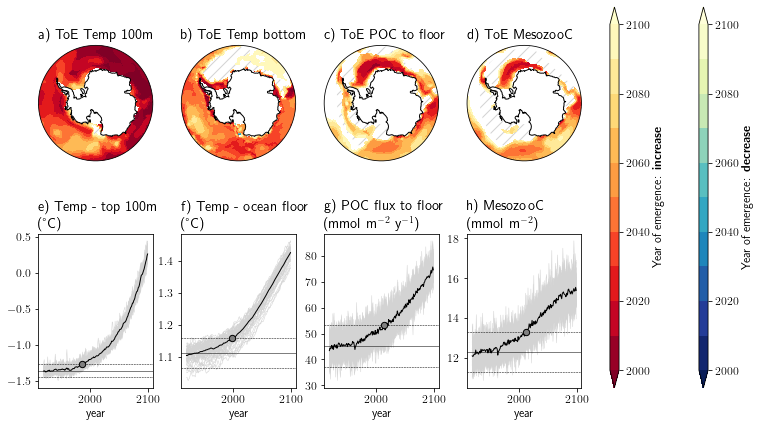

In [40]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(nrows=2, ncols=7, width_ratios=(1, 1, 1, 1, 0.08, 0.2, 0.08),height_ratios=(1,0.8))

prj =ccrs.SouthPolarStereo()


ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[0, 1], projection=prj)
ax_map3 = plt.subplot(gs[0, 2], projection=prj)
ax_map4 = plt.subplot(gs[0, 3], projection=prj)

ax_line1 = plt.subplot(gs[1, 0])
ax_line2 = plt.subplot(gs[1, 1])
ax_line3 = plt.subplot(gs[1, 2])
ax_line4 = plt.subplot(gs[1, 3])

ax_cb1 = plt.subplot(gs[0:2, 4])
ax_cb2 = plt.subplot(gs[0:2, 6])

levels=np.arange(2000,2110,10)

#########################################################
ax_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map1.set_title('a) ToE Temp 100m', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_100m)
pc1 = ax_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_100m)
pc2 = ax_map1.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.coastlines('110m',linewidth=1)

#########################################################
ax_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map2.set_title('b) ToE Temp bottom', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_TEMP_bottom)
pc1 = ax_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_TEMP_bottom)
pc2 = ax_map2.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.coastlines('110m',linewidth=1)

#########################################################
ax_map3.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map3.set_title('c) ToE POC to floor', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax_map3.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_POCfloor)
pc1 = ax_map3.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_POCfloor)
pc2 = ax_map3.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.coastlines('110m',linewidth=1)

######################
ax_map4.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map4.set_title('d) ToE MesozooC', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_siz_mask.SIZ)
pci=ax_map4.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_mesozooC)
pc1 = ax_map4.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   levels=levels, extend='both'
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_mesozooC)
pc2 = ax_map4.contourf(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   levels=levels, extend='both'
                  )
ax_map4.set_boundary(circle, transform=ax_map4.transAxes)
ax_map4.coastlines('110m',linewidth=1)

#####################
cbar1 = fig.colorbar(pc1, cax=ax_cb1,extend='both',label=r'Year of emergence: \textbf{increase}')

cbar1 = fig.colorbar(pc2, cax=ax_cb2,extend='both',label=r'Year of emergence: \textbf{decrease}')

##################################################################################################

####################################
ax_line1.set_title('e) Temp - top 100m \n (°C)',loc='left')
for mem in np.arange(0,50,1):
    ax_line1.plot(years, ts_siz['TEMP_100m'].isel(member_id=mem), color='lightgray', linewidth=0.5)
ax_line1.plot(years, ts_siz['TEMP_100m'].mean(dim='member_id'), color='black', linewidth=1)
mean = ts_siz['TEMP_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_line1.axhline(mean, color='black', linewidth=0.5)
ax_line1.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_line1.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_line1.scatter(toe_temp100m,toe_temp100m_val,s=40,color='gray',edgecolor='black',zorder=3)
ax_line1.set(xlabel='year') #,ylabel='°C');


ax_line2.set_title('f) Temp - ocean floor \n (°C)',loc='left')
for mem in np.arange(0,50,1):
    ax_line2.plot(years, ts_siz['TEMP_bottom'].isel(member_id=mem), color='lightgray', linewidth=0.5)
ax_line2.plot(years, ts_siz['TEMP_bottom'].mean(dim='member_id'), color='black', linewidth=1)
mean = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_siz['TEMP_bottom'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_line2.axhline(mean, color='black', linewidth=0.5)
ax_line2.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_line2.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_line2.scatter(toe_temp_bot,toe_temp_bot_val,s=40,color='gray',edgecolor='black',zorder=3)
ax_line2.set(xlabel='year') #,ylabel='°C');
#ax.set_ylim(0,1.6)

ax_line3.set_title('g) POC flux to floor \n  (mmol m$^{-2}$ y$^{-1}$)',loc='left')
convert = 0.01 * 86400 * 365
for mem in np.arange(0,48,1):
    ax_line3.plot(years, ts_siz['pocToFloor'].isel(member_id=mem)*convert, color='lightgray', linewidth=0.5)
ax_line3.plot(years, ts_siz['pocToFloor'].mean(dim='member_id')*convert, color='black', linewidth=1, label='POC to ocean floor')
mean = ts_siz['pocToFloor'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*convert
std = ts_siz['pocToFloor'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*convert
ax_line3.axhline(mean, color='black', linewidth=0.5)
ax_line3.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_line3.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_line3.set(xlabel='year') #,ylabel='mmol m$^{-2}$ d$^{-1}$');
ax_line3.scatter(toe_poc2floor,toe_poc2floor_val*convert,s=40,color='gray',edgecolor='black',zorder=3)

ax_line4.set_title('h) MesozooC \n (mmol m$^{-2}$)',loc='left')
for mem in np.arange(0,50,1):
    ax_line4.plot(years, ts_siz['mesozooC_zint_100m'].isel(member_id=mem)*0.01, color='lightgray', linewidth=0.5)
ax_line4.plot(years, ts_siz['mesozooC_zint_100m'].mean(dim='member_id')*0.01, color='black', linewidth=1, label='Mesozoo biomass')
mean = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.01
std = ts_siz['mesozooC_zint_100m'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.01
ax_line4.axhline(mean, color='black', linewidth=0.5)
ax_line4.axhline(mean+2*std, color='black',linestyle='--', linewidth=0.5)
ax_line4.axhline(mean-2*std, color='black',linestyle='--', linewidth=0.5)
ax_line4.scatter(toe_mesozooC,toe_mesozooC_val*0.01,s=40,color='gray',edgecolor='black',zorder=3)
ax_line4.set(xlabel='year') #,ylabel='mmol m$^{-2}$');

fig.subplots_adjust(wspace=0.4)


fig.savefig(f'{fig_dir}/FigS10_ToE_FEISTYdrivers.png', bbox_inches='tight', dpi=300, format='png');